In [1]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from collections import deque
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import IPython.display as ipythondisplay

from PIL import Image, ImageFont, ImageDraw
import io
import imageio

from time import sleep


from base64 import b64decode
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
import cv2


In [2]:

def preprocess_frame(frame):
    frame = Image.fromarray(frame)
    preprocess = transforms.Compose(
        [
            transforms.Resize((128, 128)),
            transforms.Grayscale(),
            transforms.ToTensor(),
        ]
    )

    return preprocess(frame).unsqueeze(0)

In [3]:
# preprocess = transforms.Compose([transforms.Resize((128, 128)), transforms.Grayscale()])




class Game:
    def __init__(self, html_file) -> None:
        WINDOW_SIZE = "1920,1080"

        chrome_options = webdriver.ChromeOptions()
        chrome_options.add_argument("--headless")
        chrome_options.add_argument("--window-size=%s" % WINDOW_SIZE)

        self.driver = webdriver.Chrome(options=chrome_options)
        self.driver.get(html_file)

    def getState(self):
        state = self.driver.execute_script("return getState()")
        base64_decoded = b64decode(state.split(",")[1])
        image = Image.open(io.BytesIO(base64_decoded))
        return np.array(image)

    def step(self, action):
        self.driver.execute_script(f"step({action})")
        
    def isCompleted(self):
        return self.driver.execute_script("return isCompleted()")
    
    def getReward(self):
        return self.driver.execute_script("return getReward()")

    def checkGameOver(self):
        return self.driver.execute_script("return checkGameOver()")

    def getScore(self):
        return self.driver.execute_script("return getScore()")

    def reset(self):
        self.driver.refresh()

    def close(self):
        self.driver.close()
        self.driver.quit()

In [4]:
try:
    game.close()
except:
    pass

game = Game("file:///Users/mufaddalhamid/Documents/Learn/AI_Course/bricks-breaker.html")

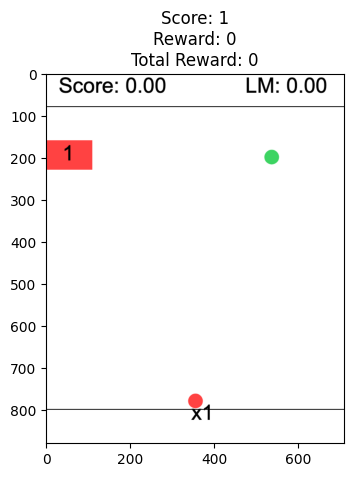

In [5]:
game.reset()
total_reward = 0
reward = 0
while not game.checkGameOver() and False:
    
    action = random.random() * 2 - 1
    # action = 0
    game.step(action)
    while True:
        state = game.getState()

        ipythondisplay.clear_output(wait=True)
        plt.imshow(state)
        plt.title(
            f"Score: {game.getScore()}\nReward: {reward}\nTotal Reward: {total_reward}"
        )
        plt.show()

        if game.isCompleted():
            break
        sleep(1/30)
    else:
        break
    reward = game.getReward()
    state = game.getState()
    total_reward += reward
    # game.display(state)
    ipythondisplay.clear_output(wait=True)
    plt.imshow(state, cmap="gray")
    plt.title(
        f"Score: {game.getScore()}\nReward: {reward}\nTotal Reward: {total_reward}"
    )
    plt.show()


state = game.getState()
ipythondisplay.clear_output(wait=True)
plt.imshow(state, cmap="gray")
plt.title(f"Score: {game.getScore()}\nReward: {reward}\nTotal Reward: {total_reward}")
plt.show()

In [6]:
game.reset()


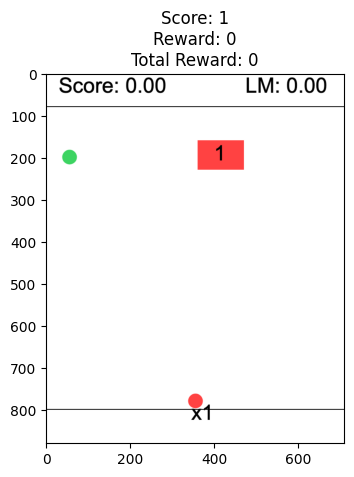

In [7]:
plt.imshow(game.getState())
plt.title(
    f"Score: {game.getScore()}\nReward: {reward}\nTotal Reward: {total_reward}"
)
plt.show()


In [8]:
game.step(0)

In [9]:
game.close()

In [10]:
class Network(nn.Module):
    def __init__(self, action_size, seed=42):
        super(Network, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=8, stride=4)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 10 * 10, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, action_size)

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.bn1(self.conv1(state)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [11]:
learning_rate = 5e-4
minibatch_size = 10
gamma = 0.99  # discount factor

In [12]:
class Agent:
    def __init__(self, action_size):
        self.device = torch.device("cpu")
        self.action_size = action_size
        self.local_qnetwork = Network(action_size).to(self.device)
        self.target_qnetwork = Network(action_size).to(self.device)
        self.optimizer = optim.Adam(self.local_qnetwork.parameters(), lr=learning_rate)
        self.memory = deque(maxlen=10000)

    def step(self, state, action, reward, next_state, done) -> None:
        state = preprocess_frame(state)
        next_state = preprocess_frame(next_state)
        self.memory.append((state, action, reward, next_state, done))
        if len(self.memory) > minibatch_size:
            experiences = random.sample(self.memory, minibatch_size)
            self.learn(experiences, gamma)

    def act(self, state, eps=0.0):
        """Returns actions for given state as per current policy."""
        state = preprocess_frame(state).to(self.device)
        self.local_qnetwork.eval()
        with torch.no_grad():
            action_values = self.local_qnetwork(state)
        self.local_qnetwork.train()

        # Epsilon-greedy action selection
        # print(action_values.cpu().data.numpy())
        # if random.random() > eps:
        #     return np.argmax(action_values.cpu().data.numpy())
        # else:
        #     return random.choice(np.arange(self.action_size))
        if random.random() > eps:
            action = action_values.squeeze().cpu().data.numpy()
            action = np.clip(action, -100, 100)
            return action
        else:
            return random.uniform(-100, 100)

    def learn(self, experiences, discount_factor):
        states, actions, rewards, next_states, dones = zip(*experiences)
        states = torch.from_numpy(np.vstack(states)).float().to(self.device)
        actions = torch.from_numpy(np.vstack(actions)).long().to(self.device)
        rewards = torch.from_numpy(np.vstack(rewards)).float().to(self.device)
        next_states = torch.from_numpy(np.vstack(next_states)).float().to(self.device)
        dones = (
            torch.from_numpy(np.vstack(dones).astype(np.uint8)).float().to(self.device)
        )
        next_q_targets = (
            self.target_qnetwork(next_states).detach().max(1)[0].unsqueeze(1)
        )
        q_targets = rewards + discount_factor * next_q_targets * (1 - dones)
        q_expected = self.local_qnetwork.forward(states)
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [13]:
agent = Agent(1)
game = Game("file:///Users/mufaddalhamid/Documents/Learn/AI_Course/bricks-breaker.html")

In [14]:
import os
import shutil

# Create the folders
os.makedirs("videos/bricks-breaker", exist_ok=True)
os.makedirs("checkpoints/bricks-breaker", exist_ok=True)

# Delete all files inside the folders
folder_paths = ["videos/bricks-breaker", "checkpoints/bricks-breaker"]
for folder_path in folder_paths:
  for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    if os.path.isfile(file_path):
      os.remove(file_path)


In [15]:
import tqdm

no_of_episodes = 2000
max_wait_time = 10000
epsilon_start = 1
epsilon_end = 0.01
epsilon_decay = 0.995
eps = epsilon_start
scores = deque(maxlen=100)  # list containing scores from last 100 episodes
last_save = ""

os.environ["IMAGEIO_FFMPEG_EXE"] = "/opt/homebrew/bin/ffmpeg"
# for episode in range(1, no_of_episodes + 1):
with tqdm.trange(1, no_of_episodes + 1) as progress_bar:
    for episode in progress_bar:
        game.reset()
        state = game.getState()
        score = 0
        frames = []
        while True:
            action = agent.act(state, eps)
            # next_state, reward, done, _, _ = game.step(action)\
            # print(action)
            game.step(action / 100)
            for _ in range(max_wait_time):
                next_state = game.getState()
                frames.append(next_state)
                if game.isCompleted():
                    break
                sleep(1 / 60)
            else:
                break
            reward = game.getReward()
            if reward == None:
                reward = 0

            next_state = game.getState()
            done = game.checkGameOver()
            # if done:
            #     reward = reward - 1000
            # reward = reward / 100
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward

            frames.append(next_state)
            if done:
                break
        imageio.mimsave(
            f"videos/bricks-breaker/video_{episode}_{score:.0f}_{eps * 1000:03.0f}.mp4",
            frames,
            fps=15,
            macro_block_size=1,
        )
        if episode % 100 == 0 or episode == 1:
            torch.save(
                agent.local_qnetwork.state_dict(),
                f"checkpoints/bricks-breaker/checkpoint_{episode}_{score:.0f}_{eps * 1000:03.0f}.pth",
            )
            last_save = f"checkpoints/bricks-breaker/checkpoint_{episode}_{score:.0f}_{eps * 1000:03.0f}.pth"
        scores.append(score)
        eps = max(epsilon_end, epsilon_decay * eps)
        progress_bar.set_description(
            f"Episode {episode}\tAverage Score: {np.mean(scores):.2f}\tCurrent Score: {score:.2f}\tEpsilon: {eps:.3f}"
        )
        if episode % 100 == 0:
            print(
                f"Episode {episode}\tAverage Score: {np.mean(scores):.2f}\tEpsilon: {eps:.3f}                          "
            )
        # if np.mean(scores) >= 2000:
        #     print(f"\nEnvironment solved in {episode:d} episodes!\tAverage Score: {np.mean(scores):.2f}\tEpsilon: {eps:.3f}")
        #     progress_bar.close()
        #     break

  0%|          | 0/2000 [00:00<?, ?it/s]

Episode 100	Average Score: -104.21	Current Score: -306.33	Epsilon: 0.606:   5%|▌         | 100/2000 [20:30<3:52:43,  7.35s/it]

Episode 100	Average Score: -104.21	Epsilon: 0.606                          


Episode 200	Average Score: -111.05	Current Score: -321.67	Epsilon: 0.367:  10%|█         | 200/2000 [40:31<3:44:49,  7.49s/it]

Episode 200	Average Score: -111.05	Epsilon: 0.367                          


Episode 300	Average Score: -88.13	Current Score: -144.00	Epsilon: 0.222:  15%|█▌        | 300/2000 [1:00:09<3:14:41,  6.87s/it]

Episode 300	Average Score: -88.13	Epsilon: 0.222                          


Episode 400	Average Score: -159.79	Current Score: -122.17	Epsilon: 0.135:  20%|██        | 400/2000 [1:14:29<3:37:23,  8.15s/it]

Episode 400	Average Score: -159.79	Epsilon: 0.135                          


Episode 500	Average Score: -130.09	Current Score: -348.00	Epsilon: 0.082:  25%|██▌       | 500/2000 [1:31:06<2:56:29,  7.06s/it] 

Episode 500	Average Score: -130.09	Epsilon: 0.082                          


Episode 600	Average Score: -135.44	Current Score: 140.08	Epsilon: 0.049:  30%|███       | 600/2000 [1:46:21<3:06:01,  7.97s/it] 

Episode 600	Average Score: -135.44	Epsilon: 0.049                          


Episode 700	Average Score: -95.07	Current Score: -206.00	Epsilon: 0.030:  35%|███▌      | 700/2000 [2:06:55<2:50:06,  7.85s/it]  

Episode 700	Average Score: -95.07	Epsilon: 0.030                          


Episode 800	Average Score: -138.98	Current Score: -361.00	Epsilon: 0.018:  40%|████      | 800/2000 [2:23:13<1:45:20,  5.27s/it] 

Episode 800	Average Score: -138.98	Epsilon: 0.018                          


Episode 900	Average Score: -24.53	Current Score: -258.00	Epsilon: 0.011:  45%|████▌     | 900/2000 [2:49:10<1:26:56,  4.74s/it]  

Episode 900	Average Score: -24.53	Epsilon: 0.011                          


Episode 1000	Average Score: -94.17	Current Score: -187.33	Epsilon: 0.010:  50%|█████     | 1000/2000 [3:13:01<1:53:38,  6.82s/it]

Episode 1000	Average Score: -94.17	Epsilon: 0.010                          


Episode 1100	Average Score: -91.93	Current Score: -144.17	Epsilon: 0.010:  55%|█████▌    | 1100/2000 [3:33:17<2:46:13, 11.08s/it] 

Episode 1100	Average Score: -91.93	Epsilon: 0.010                          


Episode 1200	Average Score: -75.54	Current Score: -328.50	Epsilon: 0.010:  60%|██████    | 1200/2000 [3:55:14<1:26:14,  6.47s/it] 

Episode 1200	Average Score: -75.54	Epsilon: 0.010                          


Episode 1300	Average Score: -39.74	Current Score: 205.14	Epsilon: 0.010:  65%|██████▌   | 1300/2000 [4:13:55<3:01:51, 15.59s/it] 

Episode 1300	Average Score: -39.74	Epsilon: 0.010                          


Episode 1400	Average Score: -44.28	Current Score: -238.00	Epsilon: 0.010:  70%|███████   | 1400/2000 [4:43:10<58:08,  5.81s/it]   

Episode 1400	Average Score: -44.28	Epsilon: 0.010                          


Episode 1500	Average Score: -93.67	Current Score: -392.62	Epsilon: 0.010:  75%|███████▌  | 1500/2000 [5:04:41<1:08:03,  8.17s/it] 

Episode 1500	Average Score: -93.67	Epsilon: 0.010                          


Episode 1600	Average Score: -11.76	Current Score: -221.06	Epsilon: 0.010:  80%|████████  | 1600/2000 [5:31:43<1:57:23, 17.61s/it] 

Episode 1600	Average Score: -11.76	Epsilon: 0.010                          


Episode 1700	Average Score: -75.77	Current Score: -394.00	Epsilon: 0.010:  85%|████████▌ | 1700/2000 [5:51:19<36:47,  7.36s/it]  

Episode 1700	Average Score: -75.77	Epsilon: 0.010                          


Episode 1800	Average Score: -66.26	Current Score: -130.33	Epsilon: 0.010:  90%|█████████ | 1800/2000 [6:12:11<1:30:08, 27.04s/it] 

Episode 1800	Average Score: -66.26	Epsilon: 0.010                          


Episode 1900	Average Score: -24.65	Current Score: -265.25	Epsilon: 0.010:  95%|█████████▌| 1900/2000 [6:39:33<10:28,  6.29s/it]  

Episode 1900	Average Score: -24.65	Epsilon: 0.010                          


Episode 2000	Average Score: -42.48	Current Score: -168.00	Epsilon: 0.010: 100%|██████████| 2000/2000 [7:01:26<00:00, 12.64s/it] 

Episode 2000	Average Score: -42.48	Epsilon: 0.010                          


In [29]:

import glob
import io
import base64
import imageio
from IPython.display import HTML, display
from gymnasium.wrappers.monitoring.video_recorder import VideoRecorder

myagent = Agent(1)
mygame = Game("file:///Users/mufaddalhamid/Documents/Learn/AI_Course/bricks-breaker.html")
# myagent.local_qnetwork.load_state_dict(torch.load("./checkpoints/bricks-breaker/checkpoint_1300_205_010.pth"))
myagent.local_qnetwork.load_state_dict(torch.load(last_save))

os.environ["IMAGEIO_FFMPEG_EXE"] = "/opt/homebrew/bin/ffmpeg"


def show_video_of_model(myagent):
    mygame.reset()
    # sleep(1)
    state = mygame.getState()
    done = False
    frames = []
    while not done:
        action = myagent.act(state)
        mygame.step(action/100)
        while True:
            next_state = mygame.getState()
            frames.append(next_state)
            if mygame.isCompleted():
                break
            sleep(1/60)
        state = next_state
        done = mygame.checkGameOver()
        
        
        
    mygame.close()
    imageio.mimsave("video.mp4", frames, fps=15)


show_video_of_model(myagent)


def show_video():
    mp4list = glob.glob("*.mp4")
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, "r+b").read()
        encoded = base64.b64encode(video)
        display(
            HTML(
                data="""<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>""".format(
                    encoded.decode("ascii")
                )
            )
        )
    else:
        print("Could not find video")


show_video()

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (710, 880) to (720, 880) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [ ]:
# import os

# os.system("say 'your program has finished'")

0